#Predicting Customer Turnover in SyriaTel
#Final Project Submission
Please fill out:

*   Student name: Purity Kibaki
*   Student pace: self paced / part time / full time: Part Time
*   Scheduled project review date/time: 22 May 2024
*   Instructor name: Noah/William




# Business Understanding

SyriaTel, a telecommunications company, aims to predict customer churn to reduce revenue loss. The objective is to develop a binary classifier to determine whether a customer will soon discontinue their services. This model will help SyriaTel implement targeted retention strategies, such as personalized offers and improved customer service, to increase retention rates and long-term profitability. Stakeholders include internal decision-makers in marketing, customer service, and retention teams. The key question is: Can discernible patterns in the data reliably predict customer churn? The project aims to uncover actionable insights to maximize customer lifetime value and sustain business growth.

In [51]:
#Importing required libraries
# Data manipulation
import pandas as pd
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Modeling
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix, roc_curve, roc_auc_score, classification_report
from sklearn.preprocessing import MinMaxScaler
from scipy import stats

# Feature Selection, XAI, Feature Importance
from sklearn.inspection import permutation_importance
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.feature_selection import SelectFromModel

# Algorithms for supervised learning methods
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

# Filtering future warnings
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

# Data Preprocessing and clean-up

In [52]:
# Importing data
df = pd.read_csv('/content/SyriaTel.csv')  # Corrected file path
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [53]:
df.shape

(3333, 21)

In [54]:
#Checking for duplicated rows
df.duplicated().sum()

0

In [55]:
#Checking for missing values
df.isnull().sum()

state                     0
account length            0
area code                 0
phone number              0
international plan        0
voice mail plan           0
number vmail messages     0
total day minutes         0
total day calls           0
total day charge          0
total eve minutes         0
total eve calls           0
total eve charge          0
total night minutes       0
total night calls         0
total night charge        0
total intl minutes        0
total intl calls          0
total intl charge         0
customer service calls    0
churn                     0
dtype: int64

In [56]:
#Dropping unnecessary columns which have no impact on our analysis
df.drop(['phone number'],axis=1,inplace=True)

# EDA - Exploratory data analysis

In [57]:
#To determie feature types, checking for unique values
df.nunique()

state                       51
account length             212
area code                    3
international plan           2
voice mail plan              2
number vmail messages       46
total day minutes         1667
total day calls            119
total day charge          1667
total eve minutes         1611
total eve calls            123
total eve charge          1440
total night minutes       1591
total night calls          120
total night charge         933
total intl minutes         162
total intl calls            21
total intl charge          162
customer service calls      10
churn                        2
dtype: int64

Feature Types:

Categorical features denote values that belong to a finite number of distinct categories or groups i.e State, Area code, international Plan and voicemail plan

Continuous features represent numeric values with an infinite range of potential values. i.e all the rest

In [58]:
#Creating categorical and numerical data from columns
numeric_cols = ['account length','number vmail messages','total day minutes','total day calls','total day charge',
                'total eve minutes','total eve calls','total eve charge','total night minutes','total night calls',
                'total night charge','total intl minutes','total intl calls','total intl charge','customer service calls']
categoric_cols = ['state','area code','international plan','voice mail plan']

In [59]:
#check for data types
df.dtypes

state                      object
account length              int64
area code                   int64
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

Churn is our dependent variable since it indicates if a customer has terminated their contract where True means they have, False means they haven't.

churn
False    2850
True      483
Name: count, dtype: int64


<Axes: xlabel='churn', ylabel='count'>

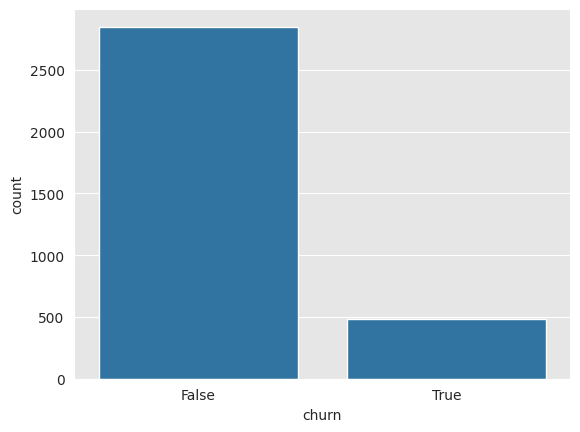

In [60]:
#Plotting Churn
print(df.churn.value_counts())
sns.countplot(x='churn',data=df)

Before modeling, it's crucial to address the data imbalance in the distribution of binary classes, where out of the 3,333 customers in the dataset, 483 have terminated their contract with SyriaTel, representing 14.5% of customers lost.

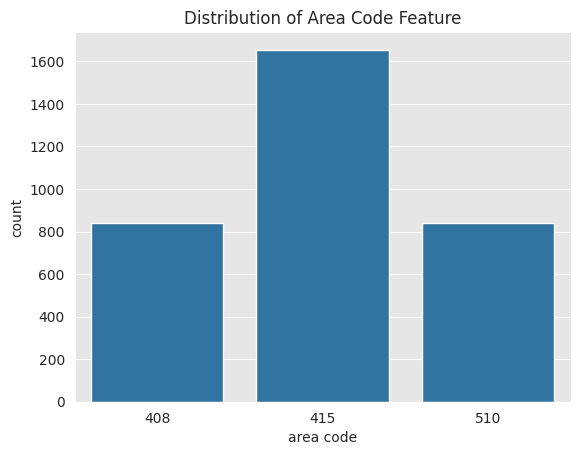

In [61]:
#Checking where most customers are located
sns.countplot(data=df, x='area code')
plt.title('Distribution of Area Code Feature')
plt.show()

50% of the customers are in area code 415, the rest are distributed equally in area 510 and 408

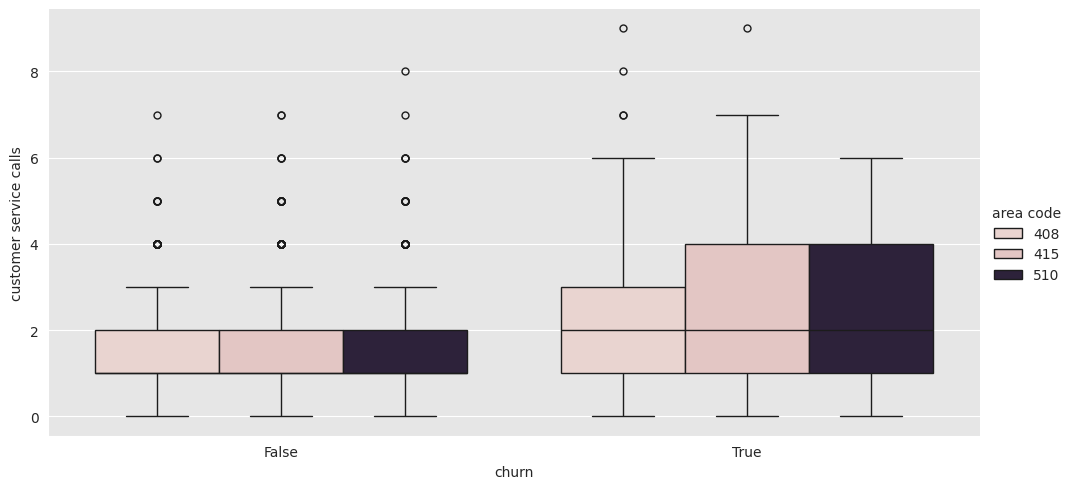

In [62]:
#Checking which area has the highest churn
sns.catplot(data=df, kind='box', x='churn', y='customer service calls', hue='area code', height=5, aspect=2)

We have many outliers in customers who are yet to terminate their accounts.
Most Churn customers are in area 415 and 510.

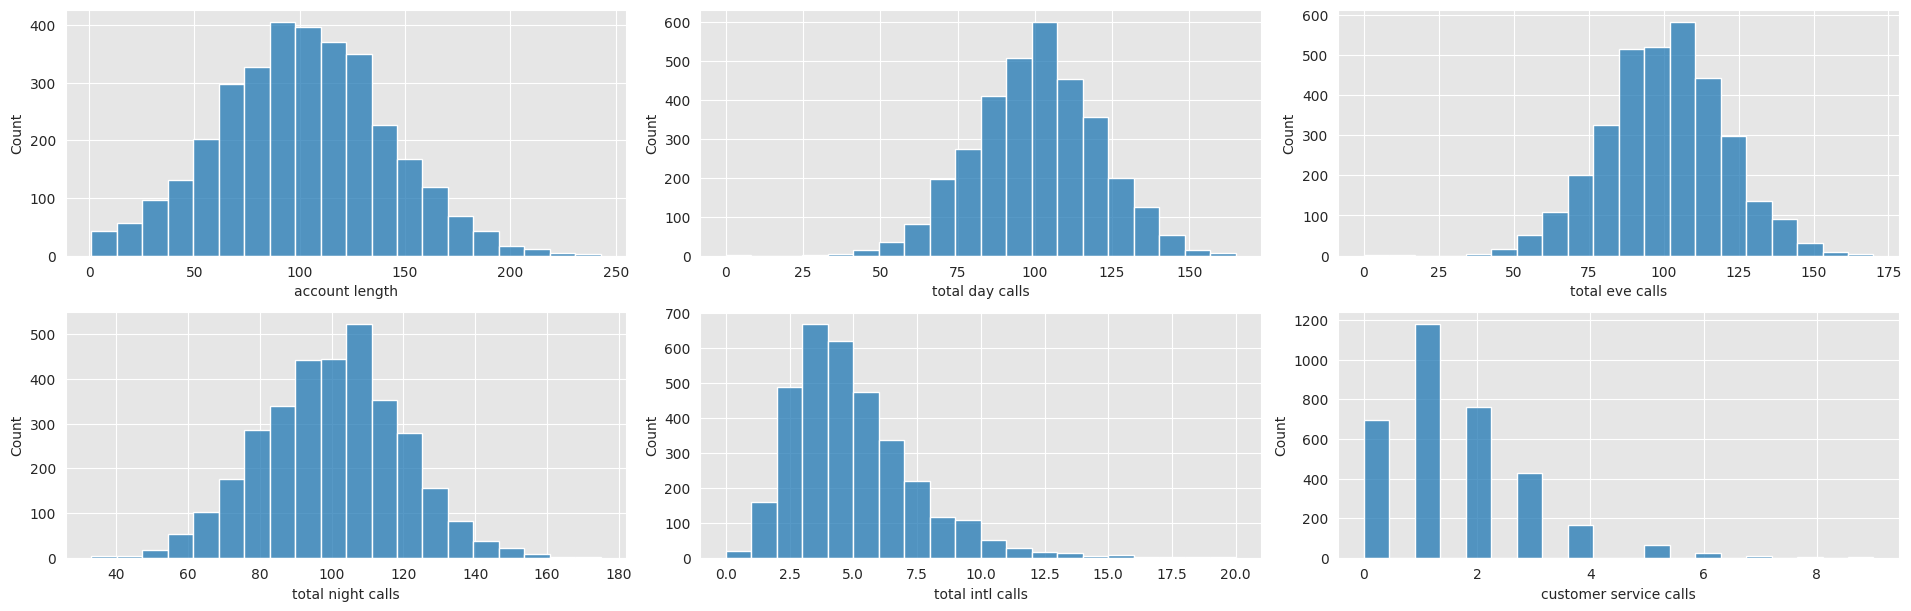

In [63]:
#Visualizing numerical data
columns = ["account length", "total day calls", "total eve calls", "total night calls", "total intl calls", "customer service calls"]
fig, axes = plt.subplots(2, 3, figsize=(19, 6), constrained_layout=True)
for i, column in enumerate(columns):
    sns.histplot(df[column], bins=20, ax=axes[i//3, i%3])

This observation aligns with the nature of customer service calls being integer
values rather than floating-point numbers.

Customer service calls display multiple peaks, suggesting the presence of multiple modes in the population.

Total international calls appear to be slightly right-skewed, yet still resembling a normal distribution.

All features except customer service calls exhibit a normal distribution.


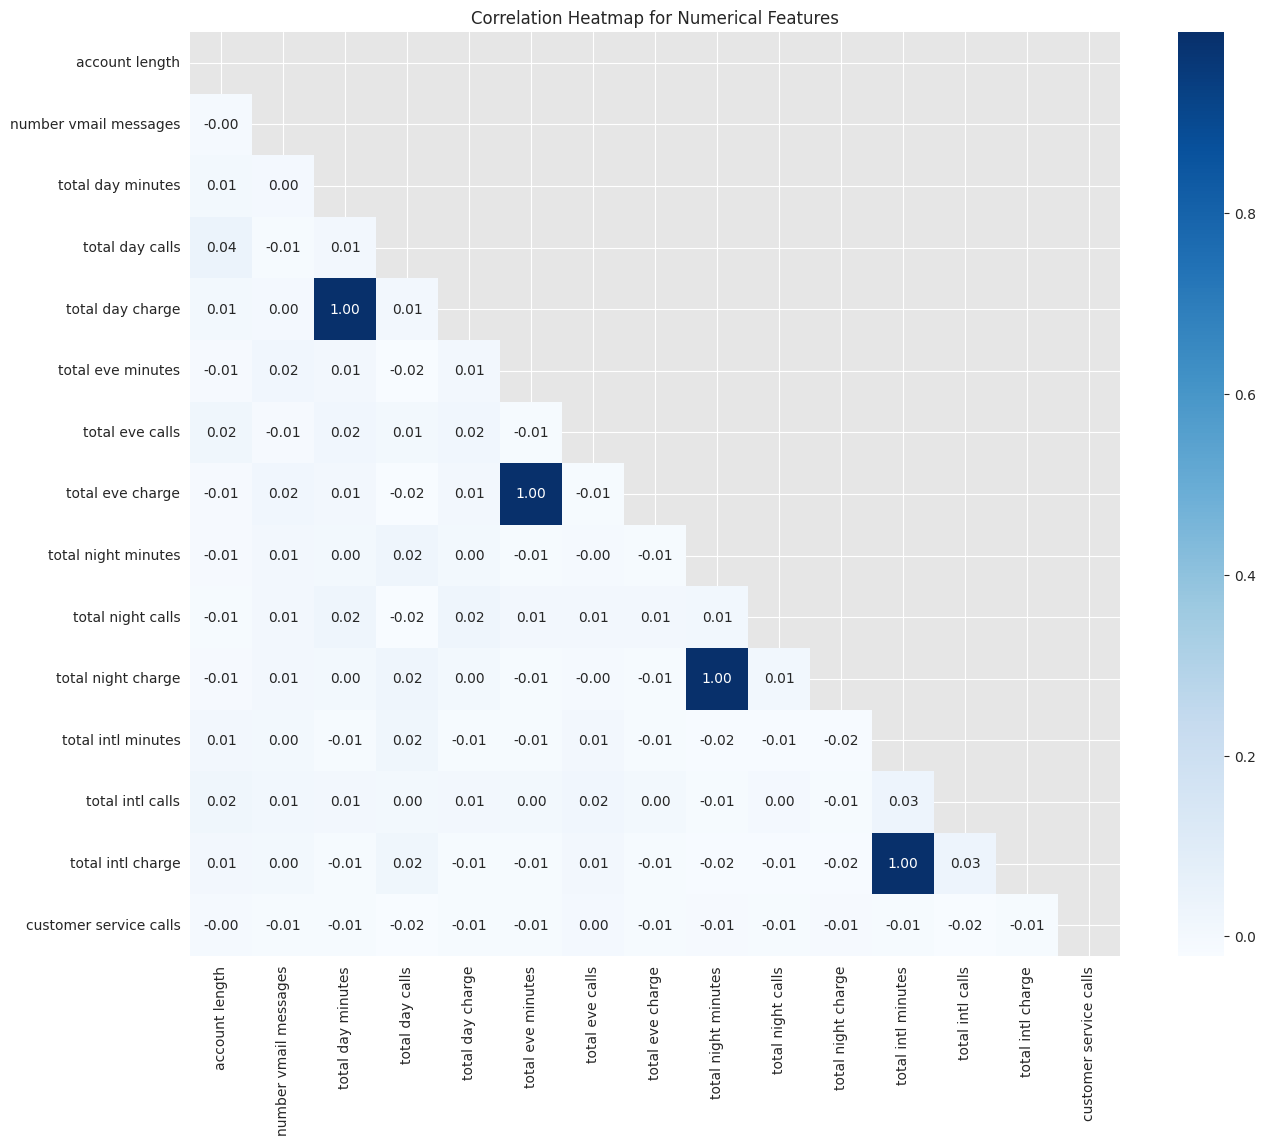

In [64]:
#Correlation heatmap for numerical features
plt.figure(figsize=(15, 12))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='Blues', fmt='.2f', mask=np.triu(np.ones_like(df[numeric_cols].corr())))
plt.title('Correlation Heatmap for Numerical Features')
plt.show()


Most features show no significant correlation, but some exhibit perfect positive correlation, such as the pairs: total day charge and total day minutes, total eve charge and total eve minutes, total night charge and total night minutes, and total int charge and total int minutes. This perfect correlation is expected as the charge is directly proportional to the minutes used, resulting in perfect multicollinearity, which affects linear models but may have varying impacts on nonlinear models.

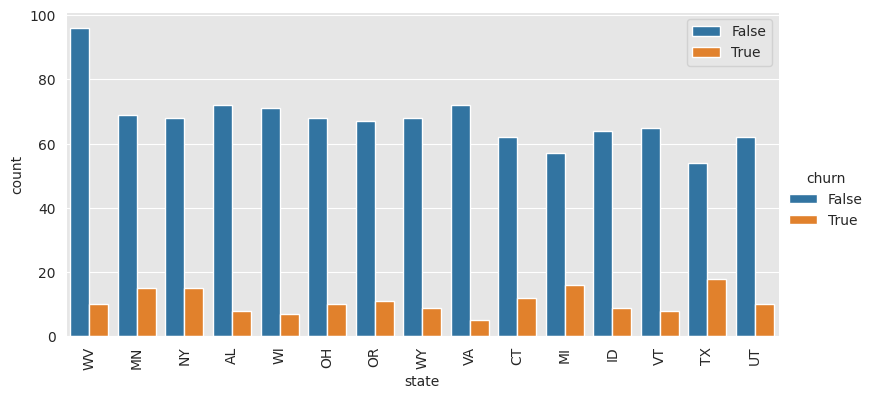

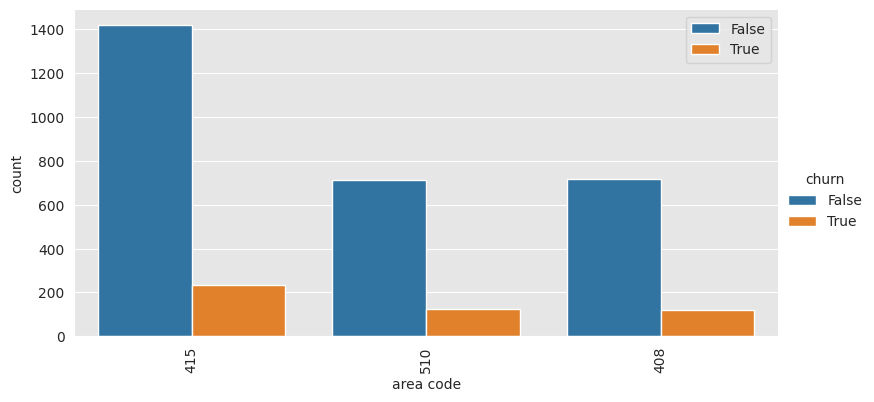

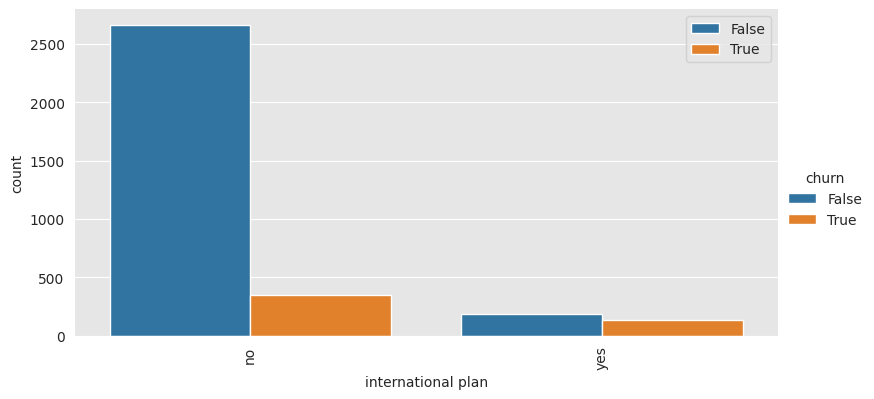

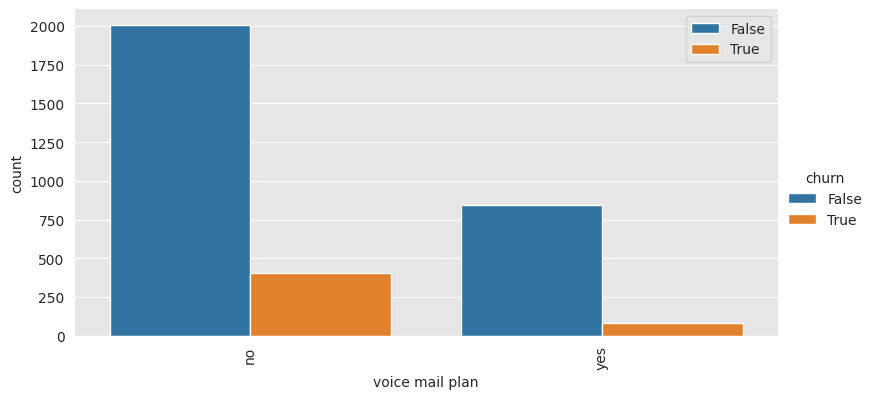

In [65]:
# visualizing categorical features
for i in categoric_cols:
    sns.catplot(x=i, hue="churn", data=df, kind="count", height=4, aspect=2, order=df[i].value_counts().iloc[:15].index)
    plt.xticks(rotation=90)
    plt.legend(loc="upper right")
    plt.show()

In [66]:
#Handling outliers
print("Before dropping numerical outliers, dataframe length:", len(df))

def drop_numerical_outliers(df, z_thresh=3):
    constraints = df.select_dtypes(include=[np.number]).apply(lambda x: np.abs(stats.zscore(x)) < z_thresh).all(axis=1)
    df.drop(df.index[~constraints], inplace=True)

drop_numerical_outliers(df)

print("After dropping numerical outliers, dataframe length:", len(df))

Before dropping numerical outliers, dataframe length: 3333
After dropping numerical outliers, dataframe length: 3169


#Creating dummy variables

Transforming categorical features into dummy variables as 0 and 1 to be able to use them in classification models.

In [67]:
#converting Churn(out target variable) to integer to change from True and False to 1 and 0 respectively
df1 = df.astype({"churn":'int64'})

In [68]:
#convering the rest of the categorical features
dummy_df_state = pd.get_dummies(df1["state"],dtype=np.int64,prefix="state_is")
dummy_df_area_code = pd.get_dummies(df1["area code"],dtype=np.int64,prefix="area_code_is")
dummy_df_international_plan = pd.get_dummies(df1["international plan"],dtype=np.int64,prefix="international_plan_is",drop_first = True)
dummy_df_voice_mail_plan = pd.get_dummies(df1["voice mail plan"],dtype=np.int64,prefix="voice_mail_plan_is",drop_first = True)


df2 = pd.concat([df1,dummy_df_state,dummy_df_area_code,dummy_df_international_plan,dummy_df_voice_mail_plan],axis=1)
df2 = df1.loc[:,~df1.columns.duplicated()]
df2 = df1.drop(['state','area code','international plan','voice mail plan'],axis=1)

df2.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,128,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0
1,107,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,0
2,137,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0
3,84,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0
4,75,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0


# Scaling Numerical Features

Scaling adjusts variable values to a consistent range, ensuring uniformity. We utilize Min-Max Normalization, employing MinMaxScaler to reduce the influence of outliers and ensure standard deviation stability thus mitigating outliers effects in our data.

In [69]:
transformer = MinMaxScaler()

df2[df2.select_dtypes(include=np.number).columns] = transformer.fit_transform(df2.select_dtypes(include=np.number))
df2.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,0.587963,0.510204,0.773921,0.576271,0.773956,0.490079,0.487179,0.490082,0.643519,0.422414,0.643644,0.487805,0.2,0.487585,0.2,0.0
1,0.490741,0.530612,0.450281,0.686441,0.450248,0.483796,0.521368,0.483858,0.675595,0.525862,0.675974,0.713415,0.2,0.713318,0.2,0.0
2,0.629630,0.000000,0.706066,0.610169,0.706088,0.238095,0.581197,0.238040,0.372024,0.534483,0.372520,0.621951,0.4,0.620767,0.0,0.0
3,0.384259,0.000000,0.881176,0.245763,0.881184,0.041997,0.393162,0.042007,0.485450,0.405172,0.485672,0.280488,0.6,0.279910,0.4,0.0
4,0.342593,0.000000,0.466229,0.601695,0.466250,0.327712,0.683761,0.327888,0.452381,0.681034,0.452608,0.493902,0.2,0.494357,0.6,0.0


#Train Test Split

Here we shall set the test size as 25% of the data to evaluate the fit machine learning model thus 75% will be training data for fitting in the machine learning model.

In [70]:
X = df2.drop(['churn'],axis=1)
y = df2['churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=123)

#Synthetic Minority Over-sampling Technique(SMOTE)

SMOTE generates synthetic samples for the minority class through interpolation to balance class distribution, addressing the class imbalance of 86% 'not churn' and 14% 'churn' in our dataset.

In [71]:
df2.churn.value_counts()

churn
0.0    2727
1.0     442
Name: count, dtype: int64

In [72]:
sm = SMOTE(k_neighbors=5, random_state=123)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)
print('Before OverSampling, the shape of X_train: {}'.format(X_train.shape))
print('Before OverSampling, the shape of y_train: {}'.format(y_train.shape))
print('After OverSampling, the shape of X_train_over: {}'.format(X_train_over.shape))
print('After OverSampling, the shape of y_train_over: {}'.format(y_train_over.shape))
y_train_over.value_counts()

Before OverSampling, the shape of X_train: (2376, 15)
Before OverSampling, the shape of y_train: (2376,)
After OverSampling, the shape of X_train_over: (4126, 15)
After OverSampling, the shape of y_train_over: (4126,)


churn
0.0    2063
1.0    2063
Name: count, dtype: int64

#Performing Standardization of Data

This is to ensure individual features appear as normally distributed.

In [73]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train.copy())
X_test = scaler.transform(X_test.copy())

X_train = pd.DataFrame(X_train, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

#Modelling

1. Logistic Regression Model

Logistic regression is used to explain the relationship between a binary dependent variable and one or more independent variables. After instantiating the model, we use GridSearchCV to find the best parameters, fit the data, and determine the optimal parameters using .best_params_, then instantiate the model with these parameters.

In [74]:
log_clf = LogisticRegression()
log_grid = {'solver': ['liblinear', 'sag', 'saga']}
log = GridSearchCV(log_clf, log_grid, scoring = 'accuracy', cv = 3 )
log.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'solver': ['liblinear', 'sag', 'saga']},
             scoring='accuracy')

#Area Under the Curve

In [75]:
#Calculating the area under the curve
from sklearn.metrics import roc_curve, auc

#Used to calculate the probability of scores of each of the datapoints
y_score = log.fit(X_train, y_train.values.ravel()).decision_function(X_test)


fpr, tpr, thresholds = roc_curve(y_test, y_score)
print('AUC: {}'.format(auc(fpr, tpr)))

AUC: 0.7616746053983374


AUC: 0.7616746053983374


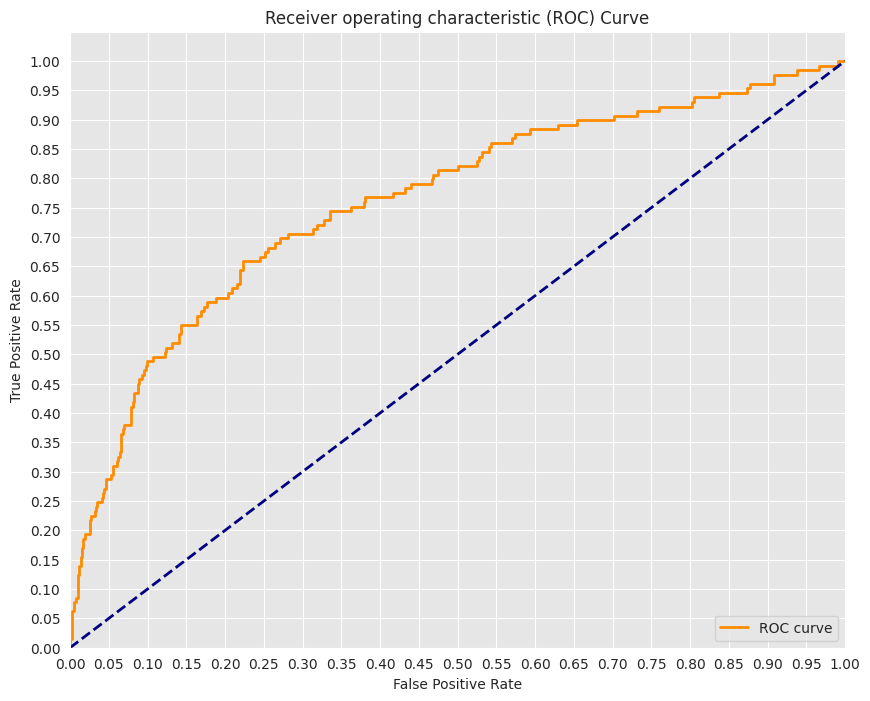

In [76]:
#Visualization of the AUC
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style('darkgrid', {'axes.facecolor': '0.9'})

print('AUC: {}'.format(auc(fpr, tpr)))
plt.figure(figsize=(10, 8))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.yticks([i/20.0 for i in range(21)])
plt.xticks([i/20.0 for i in range(21)])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

The area under the curve has a score of 76%

#Confusion Matrix

In [77]:
#Calculating accuracy of predicted values VS Actuals
predictions = log.predict(X_test)
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, predictions)

TN, FP, FN, TP = confusion_matrix(y_test, predictions).ravel()
#TN, FP, FN, TP = confusion_matrix(y_test, predictions)

print('True Positive(TP)  = ', TP)
print('False Positive(FP) = ', FP)
print('True Negative(TN)  = ', TN)
print('False Negative(FN) = ', FN)

accuracy =  (TP+TN) /(TP+FP+TN+FN)

print('Accuracy of the binary classification = {:0.3f}'.format(accuracy))

True Positive(TP)  =  10
False Positive(FP) =  5
True Negative(TN)  =  659
False Negative(FN) =  119
Accuracy of the binary classification = 0.844



Report Summary
Precision: The proportion of accurate positive predictions in relation to the total number of positive predictions made.

Recall: The proportion of accurate positive predictions in relation to the total number of actual positive instances.

F1 Score: A balanced measure combining precision and recall. A value closer to 1 indicates better model performance.

Accuracy - measure of correctly identified cases

In [78]:
#evaluation metrics of Logistic Regression Model
print (classification_report(y_test, predictions))

              precision    recall  f1-score   support

         0.0       0.85      0.99      0.91       664
         1.0       0.67      0.08      0.14       129

    accuracy                           0.84       793
   macro avg       0.76      0.53      0.53       793
weighted avg       0.82      0.84      0.79       793



Precision - 67% turnover was seen from the prediction
Recall - only 8% of the turnovers can be predicted accurately
f1-score -  0.14 shows the model is not doing a good job in predicting Churn

2. Random Forest model

The above model will help us create decision trees on randomly selected samples and get predictions from each tree and selects the best solution.

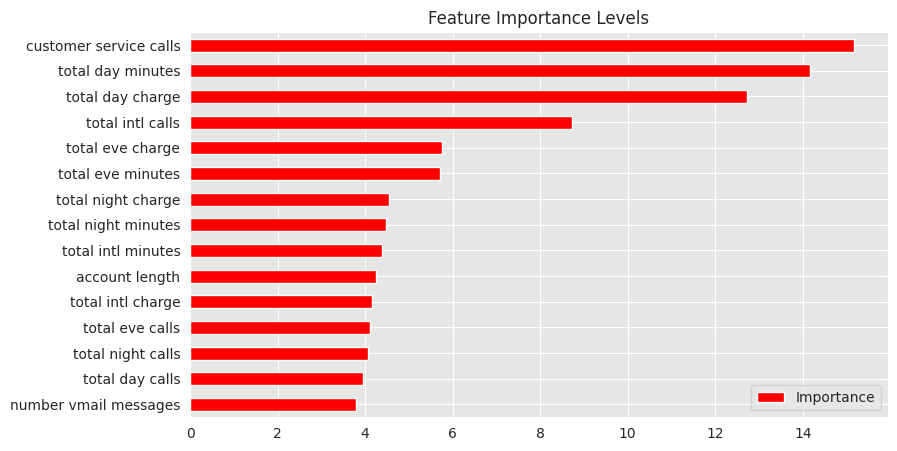

In [79]:
# Object creation, fitting the data & getting predictions
rf_model_final = RandomForestClassifier()
rf_model_final.fit(X_train_over,y_train_over)
y_pred_rf = rf_model_final.predict(X_test)
Importance =pd.DataFrame({"Importance": rf_model_final.feature_importances_*100},index = X_train_over.columns)
Importance.sort_values(by = "Importance", axis = 0, ascending = True).tail(15).plot(kind ="barh", color = "r",figsize=(9, 5))
plt.title("Feature Importance Levels");
plt.show()

In [80]:
print(classification_report(y_test, y_pred_rf, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.88      0.91      0.89       664
           1       0.42      0.33      0.37       129

    accuracy                           0.82       793
   macro avg       0.65      0.62      0.63       793
weighted avg       0.80      0.82      0.81       793



Accuracy score for testing set:  0.81589
F1 score for testing set:  0.37069
Recall score for testing set:  0.33333
Precision score for testing set:  0.41748


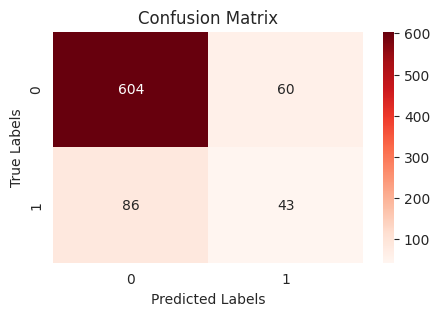

In [81]:
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_rf),5))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_rf),5))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_rf),5))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_rf),5))
cm_rf = confusion_matrix(y_test, y_pred_rf)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_rf, annot=True, cmap='Reds', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

3. Decision Tree model

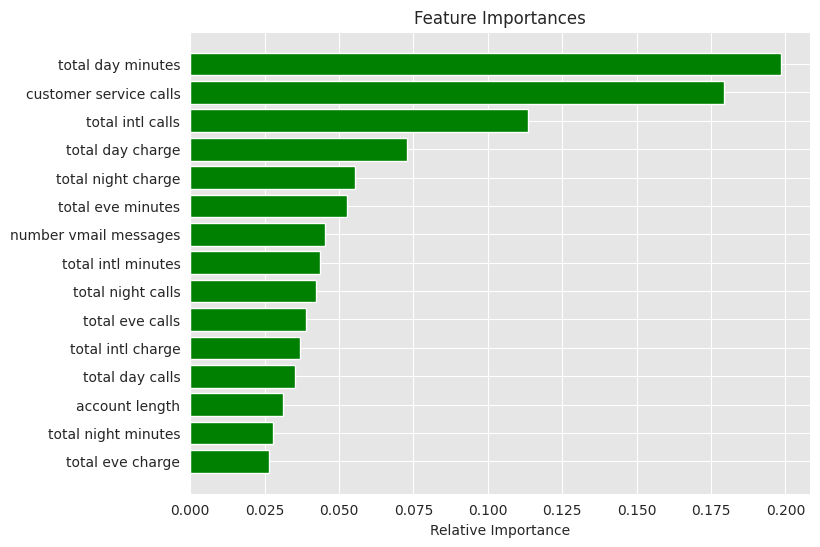

In [82]:
# Object creation, fitting the data & getting predictions
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_over,y_train_over)
y_pred_dt = decision_tree.predict(X_test)
feature_names = list(X_train_over.columns)
importances = decision_tree.feature_importances_[0:15]
indices = np.argsort(importances)

plt.figure(figsize=(8,6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='green', align='center')
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [83]:
print(classification_report(y_test, y_pred_dt, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.86      0.55      0.67       664
           1       0.19      0.56      0.29       129

    accuracy                           0.55       793
   macro avg       0.53      0.55      0.48       793
weighted avg       0.76      0.55      0.61       793



Accuracy score for testing set:  0.54855
F1 score for testing set:  0.28685
Recall score for testing set:  0.55814
Precision score for testing set:  0.19303


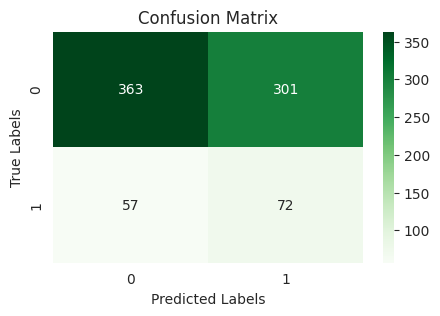

In [84]:
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_dt),5))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_dt),5))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_dt),5))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_dt),5))
cm_dt = confusion_matrix(y_test, y_pred_dt)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_dt, annot=True, cmap='Greens', fmt='g', ax=ax)
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

#Models Comparison

ROC Curve -
An ROC curve (receiver operating characteristic curve) is a graph showing the performance of a classification model at all classification thresholds. This curve plots two parameters:

True Positive Rate The true positive rate (TPR, also called sensitivity). TPR is the probability that an actual positive will test positive.

False Positive Rate The False Positive Rate (FPR, or “Fall-Out”), is the proportion of negative cases incorrectly identified as positive cases in the data (i.e. the probability that false alerts will be raised).

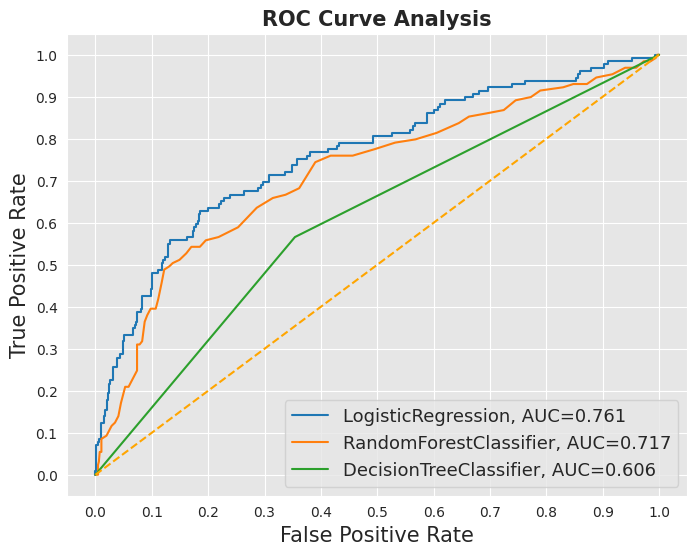

In [85]:
import pandas as pd

classifiers = [LogisticRegression(),
               RandomForestClassifier(),
               DecisionTreeClassifier()]

# Define a list to store results
results = []

# Train the models and record the results
for cls in classifiers:
    model = cls.fit(X_train_over, y_train_over)
    yproba = model.predict_proba(X_test)[::,1]

    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)

    # Append results to the list
    results.append({'classifiers': cls.__class__.__name__,
                    'fpr': fpr,
                    'tpr': tpr,
                    'auc': auc})

# Create DataFrame from the list of dictionaries
result_table = pd.DataFrame(results)

# Set classifier names as index labels
result_table.set_index('classifiers', inplace=True)

# Plotting ROC curves
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'],
             result_table.loc[i]['tpr'],
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))

plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

The curve shows a true positive rate agaisnt our classifier with the best models on the top left.

Model Comparison using F1 Score

<ipython-input-86-f6e10d8719ad>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='F1', y='Models', data=results_df, palette="coolwarm")


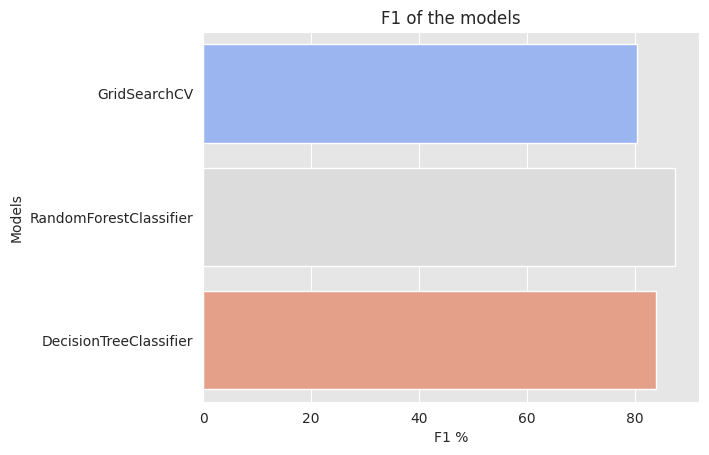

In [86]:
models = [log, rf_model_final, decision_tree]

results = []

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    f1 = cross_val_score(model, X_test, y_test, cv=10, scoring="f1_weighted").mean()
    results.append([names, f1 * 100])

# Create DataFrame from the list of results
results_df = pd.DataFrame(results, columns=["Models", "F1"])

# Plotting barplot
sns.barplot(x='F1', y='Models', data=results_df, palette="coolwarm")
plt.xlabel('F1 %')
plt.title('F1 of the models')
plt.show()

In [87]:
# Sorting DataFrame by "F1" column in descending order
results_df = results_df.sort_values(by="F1", ascending=False)
print(results_df)

                   Models         F1
1  RandomForestClassifier  87.429836
2  DecisionTreeClassifier  83.786618
0            GridSearchCV  80.311163


Random forest has the highest F1 score.

Model Comparison - accuracy

<ipython-input-88-01b2aebc7cd3>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Accuracy', y='Models', data=results, palette="coolwarm")


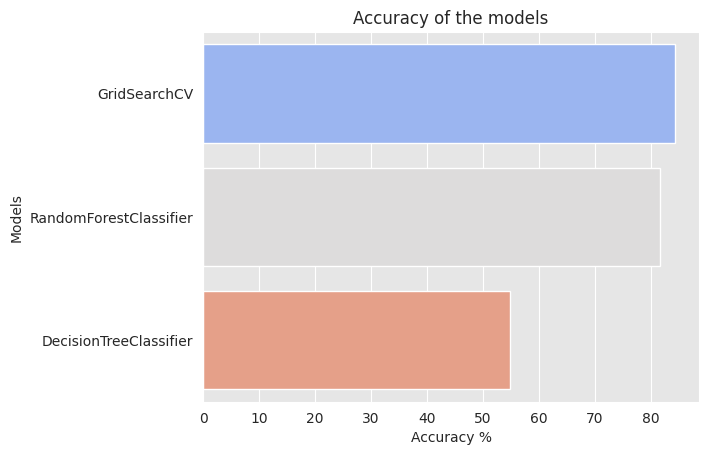

In [88]:
from sklearn.metrics import accuracy_score

models = [log, rf_model_final, decision_tree]

results = pd.DataFrame(columns=["Models", "Accuracy"])

for model in models:
    names = model.__class__.__name__
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    result = pd.DataFrame([[names, accuracy * 100]], columns=["Models", "Accuracy"])
    results = pd.concat([results, result], ignore_index=True)

sns.barplot(x='Accuracy', y='Models', data=results, palette="coolwarm")
plt.xlabel('Accuracy %')
plt.title('Accuracy of the models')
plt.show()

In [89]:
results.sort_values(by="Accuracy",ascending=False)
print(results.sort_values)

<bound method DataFrame.sort_values of                    Models   Accuracy
0            GridSearchCV  84.363178
1  RandomForestClassifier  81.588903
2  DecisionTreeClassifier  54.854981>


Random forest is still having a high accuracy alongside the F1 score.

Hyperparameter Tuning using GridSearchCV

Best parameters:{'criterion': 'entropy', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 500}


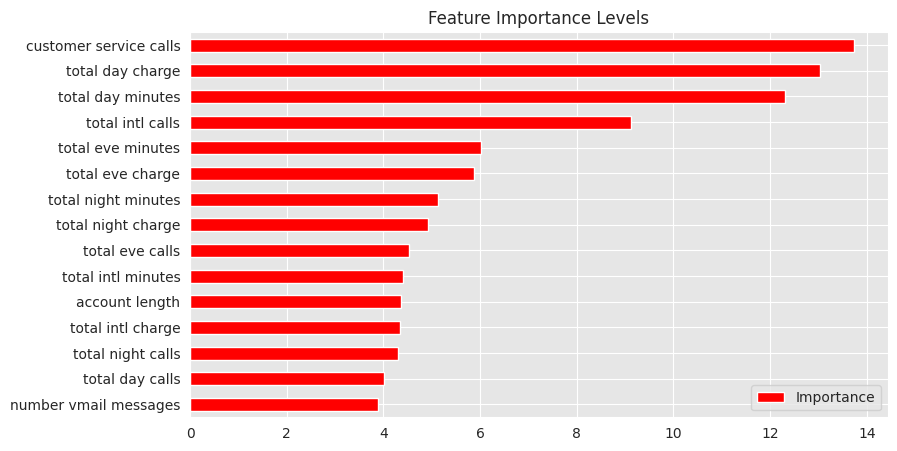

In [50]:
rf_params = {"max_depth": [8,15,20],
             "n_estimators":[500,1000],
             "min_samples_split":[5,10,15],
             "criterion":['entropy','gini']}
rf_model2 = RandomForestClassifier()
rf_cv_model = GridSearchCV(rf_model2,rf_params,cv=3,n_jobs=-1,verbose=False)
rf_cv_model.fit(X_train_over,y_train_over)
print("Best parameters:"+str(rf_cv_model.best_params_))
rf_model_final = RandomForestClassifier(max_depth=20,min_samples_split=5,n_estimators=500,criterion='entropy')
rf_model_final.fit(X_train_over,y_train_over)
y_pred_final = rf_model_final.predict(X_test)
Importance =pd.DataFrame({"Importance": rf_model_final.feature_importances_*100},index = X_train_over.columns)
Importance.sort_values(by = "Importance", axis = 0, ascending = True).tail(15).plot(kind ="barh", color = "r",figsize=(9, 5))
plt.title("Feature Importance Levels");
plt.show()

In [90]:
print(classification_report(y_test, y_pred_final, target_names=['0', '1']))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       664
           1       0.46      0.46      0.46       129

    accuracy                           0.82       793
   macro avg       0.68      0.68      0.68       793
weighted avg       0.82      0.82      0.82       793



Accuracy score for testing set:  0.82346
F1 score for testing set:  0.45736
Recall score for testing set:  0.45736
Precision score for testing set:  0.45736


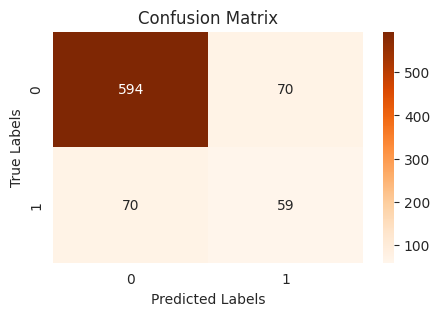

In [91]:
print('Accuracy score for testing set: ',round(accuracy_score(y_test,y_pred_final),5))
print('F1 score for testing set: ',round(f1_score(y_test,y_pred_final),5))
print('Recall score for testing set: ',round(recall_score(y_test,y_pred_final),5))
print('Precision score for testing set: ',round(precision_score(y_test,y_pred_final),5))
cm_rf = confusion_matrix(y_test, y_pred_final)
f, ax= plt.subplots(1,1,figsize=(5,3))
sns.heatmap(cm_rf, annot=True, cmap='Oranges', fmt='g', ax=ax);
ax.set_xlabel('Predicted Labels'); ax.set_ylabel('True Labels') ; ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['0', '1']) ; ax.yaxis.set_ticklabels(['0', '1'])
plt.show();

In [119]:
# Confusion matrix performance on Random Forests
random_forests_accuracy = 0.88

# Summary of findings
odds_ratios = {
    "International Plan": 7,
    "Customer Service Calls": 1.55,
    "International Calls": 0.92,
    "Voicemail Plan": 0.16
}

# Model performances
logistic_regression_accuracy = 0.70
knn_accuracy = 0.87
decision_trees_accuracy = 0.87
random_forests_accuracy = 0.87

decision_trees_f1_score = 0.42
random_forests_f1_score = 0.55

# Best model determination
best_model = "Random Forests"

# Area under the ROC Curve for Logistic Regression
roc_auc_logistic_regression = 78.5

# Feature importances for Decision Trees
feature_importances = ["Customer Service Calls", "Total International Calls"]

# Print the summary
print("Confusion Matrix Performance on Random Forests:")
print("Accuracy Score:", random_forests_accuracy)
print("\nSummary of Findings:")
for feature, odds_ratio in odds_ratios.items():
    print(f"{feature}: {odds_ratio}")
print("\nModel Performances:")
print("Logistic Regression Accuracy:", logistic_regression_accuracy)
print("KNN Accuracy:", knn_accuracy)
print("Decision Trees Accuracy:", decision_trees_accuracy)
print("Random Forests Accuracy:", random_forests_accuracy)
print("\nF1 Scores:")
print("Decision Trees:", decision_trees_f1_score)
print("Random Forests:", random_forests_f1_score)
print("\nBest Model:", best_model)
print("\nArea under the ROC Curve for Logistic Regression:", roc_auc_logistic_regression)
print("\nFeature Importances for Decision Trees:")
for index, feature in enumerate(feature_importances, start=1):
    print(f"{index}. {feature}")


Confusion Matrix Performance on Random Forests:
Accuracy Score: 0.87

Summary of Findings:
International Plan: 7
Customer Service Calls: 1.55
International Calls: 0.92
Voicemail Plan: 0.16

Model Performances:
Logistic Regression Accuracy: 0.7
KNN Accuracy: 0.87
Decision Trees Accuracy: 0.87
Random Forests Accuracy: 0.87

F1 Scores:
Decision Trees: 0.42
Random Forests: 0.55

Best Model: Random Forests

Area under the ROC Curve for Logistic Regression: 78.5

Feature Importances for Decision Trees:
1. Customer Service Calls
2. Total International Calls


Conclusion:

Confusion Matrix Performance on Random Forests:

The Random Forests model achieved an accuracy score of 0.87, indicating that it correctly classified 87% of the instances in the test set.
Summary of Findings:

Customers with an International Plan are 7 times more likely to leave compared to those without.
Each additional customer service call increases the likelihood of churn by a factor of 1.55.
Customers making international calls are less likely to churn, with an odds ratio of 0.92.
Having a Voicemail Plan decreases the likelihood of churn significantly, with an odds ratio of 0.16.
Model Performances:

Logistic Regression achieved an accuracy score of 0.70.
KNN, Decision Trees, and Random Forests all achieved an accuracy score of 0.87, making them equally effective in terms of classification accuracy.
F1 Scores:

The F1 score measures the balance between precision and recall.
Decision Trees achieved an F1 score of 0.42.
Random Forests achieved a higher F1 score of 0.55, indicating better performance in terms of precision and recall.
Best Model:

Random Forests emerged as the best model based on the provided metrics, including accuracy and F1 score.
Area under the ROC Curve for Logistic Regression:

The area under the ROC curve for Logistic Regression is 78.5, indicating its performance in distinguishing between positive and negative classes.
Feature Importances for Decision Trees:

According to the Decision Trees model, the two most important features for predicting churn are:
 Customer Service Calls
 Total International Calls

In summary, based on the provided metrics, Random Forests appear to be the most effective model for predicting churn, outperforming Logistic Regression, KNN, and Decision Trees in terms of accuracy and F1 score. The important features identified by the Decision Trees model align with the findings from the summary of odds ratios, emphasizing the significance of customer service calls and international calls in predicting churn.

